In [51]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from bsgp.models import RegressionModel
from pprint import pprint
import ipywidgets as widgets
import tensorflow_probability as tfp

Utility function to set the seed

In [52]:
def set_seed(seed):
    import random
    random.seed(seed)
    np.random.seed(seed)
    tf.compat.v1.set_random_seed(seed)

Utility functions to plot the precision matrix $\Lambda$

In [53]:
def plot_precision(precision_matrix):
    plt.figure()
    max = np.max(precision_matrix)
    sns.heatmap(precision_matrix, annot=True, cmap='vlag', vmax=max, vmin=-max, center=0, linewidth=.5)
    plt.show()

Utility functions to generate precision matrix $\Lambda$ with only diagonal or also with off-diagonal non-zero elements

In [54]:
def random_diag_precision(D):
    return np.diag(np.random.uniform(0,1,D))
def random_notdiag_precision(D):
    sparsity = 0.5
    precision = np.random.rand(D, D)
    precision[precision < sparsity] = 0
    precision = np.triu(precision) + np.triu(precision, 1).T
    return precision
def random_offdiag_precision(D, random_offdiag='no', n_offdiag=1):
    diag = np.ones(D)
    L = np.diag(diag, 0)
    if n_offdiag > D-1:
        n_offdiag = D-1
    for n in range(n_offdiag):
        i = n+1
        # define the offdiagonal
        if random_offdiag == 'no':
            offdiag = D**0.5 * np.ones(D-i)
        elif random_offdiag == 'uniform':
            offdiag = np.random.uniform(0, 1, D-i)
        elif random_offdiag == 'gaussian':
            offdiag = np.random.normal(-1, 1, D-i)
        # add it to the matrix L
        L += np.diag(offdiag, -i)
    # define the precision matrix
    precision = L @ L.T
    # normalize the precision matrix to have ones on the diagonal
    diag_m = np.diag(1/np.diag(precision))
    return (np.sqrt(diag_m) @ precision) @ np.sqrt(diag_m)

Utility function to compute the kernel matrix $K_{xx|\Theta}$:
$$
k_{LRBF}(\mathbf{x,x';\Lambda}) = \sigma_f^2exp\left(-\frac{1}{2}(\mathbf{x-x'})^T\mathbf{\Lambda}(\mathbf{x-x'})\right) ,\qquad \mathbf{\Lambda}=\mathbf{\Sigma}^{-1} \in \mathrm{R}^{DxD}
$$

In [14]:
def _z(X, Lambda):
        XLambda = X @ Lambda
        XLambdaX = np.multiply(XLambda, X)
        return np.sum(XLambdaX, axis=1, keepdims=True)
def K_lrbf(kernel_variance, X, Lambda, X2=None):
    """
            X: matrix NxD
            X2: matrix NxD
            ---
            Returns Kernel matrix as a 2D tensor
    """
    if X2 is None:
        X2 = X
    N1 = X.shape[0]
    N2 = X2.shape[0]

    # compute z, z2
    z = _z(X, Lambda) # N1x1 array
    z2 = _z(X2, Lambda) # N2x1 array
    # compute X(X2Λ)ᵀ
    X2Lambda = X2 @ Lambda
    XX2LambdaT = X @ X2Lambda.T # N1xN2 matrix
    # compute z1ᵀ 
    ones_N2 = np.ones(shape=(N2,1)) # N2x1 array
    zcol = z @ ones_N2.T # N1xN2 matrix
    # compute 1z2ᵀ 
    ones_N1 = np.ones(shape=(N1,1)) # N1x1 array
    zrow = ones_N1 @ z2.T # N1xN2 matrix

    exp_arg = zcol - 2*XX2LambdaT + zrow
    Kxx = np.exp(-0.5 * exp_arg)
    return kernel_variance * Kxx

Utility function to generate the toy dataset

In [56]:
def generate_dataset(precision, covariance, n=100, kernel_variance=1.0, noise_variance=0.1, random_state=0):
    d = covariance.shape[0]
    # sampling from known covariance 
    X = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=n)
    K = K_lrbf(kernel_variance, X, precision)
    noise = np.random.normal(0, noise_variance, size=n)
    Y = (np.random.multivariate_normal(np.zeros(n), K, size=1) + noise).reshape(-1,1)
    # train-test split
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0) # center the dataset
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state, shuffle=True)
    Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
    Y_train = (Y_train - Y_train_mean) / Y_train_std
    Y_test = (Y_test - Y_train_mean) / Y_train_std
    return X_train, Y_train, X_test, Y_test, Y_train_mean, Y_train_std

Define $D$ and create a precision matrix

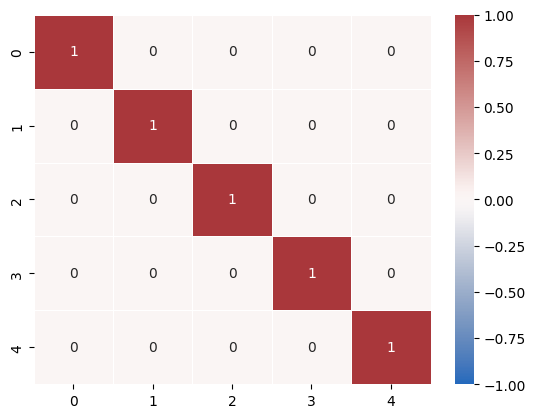

In [55]:
D = 5
precision = random_offdiag_precision(D, random_offdiag='gaussian', n_offdiag=0)
covariance = np.linalg.inv(precision) 
plot_precision(precision)

Generate the toy dataset specifying the parameters

In [57]:
X_train, Y_train, X_test, Y_test, Y_train_mean, Y_train_std = generate_dataset(precision, covariance, noise_variance=0.1, kernel_variance=1, n=500)

Train the model with Full-precision kernel

In [45]:
prior_type = 'normal'
num_inducing = 100
minibatch_size = 1000
iterations = 1024
n_layers = 1
num_posterior_samples = 256
step_size = 0.01

In [46]:
set_seed(0)
if minibatch_size > len(X_train): minibatch_size = len(X_train)
model = RegressionModel(prior_type)
model.ARGS.num_inducing = num_inducing
model.ARGS.minibatch_size = minibatch_size
model.ARGS.iterations = iterations
model.ARGS.n_layers = n_layers
model.ARGS.num_posterior_samples = num_posterior_samples
model.ARGS.prior_type = prior_type
model.ARGS.full_cov = False
model.ARGS.posterior_sample_spacing = 32
print('Number of inducing points: %d' % model.ARGS.num_inducing)
model.ARGS.precise_kernel = 1 
model.fit(X_train, Y_train, epsilon=step_size)
test_mll = model.calculate_density(X_test, Y_test, Y_train_mean, Y_train_std).mean().tolist()
#save_results(filepath, test_mll, precise_kernel, model.posterior_samples_kerncov, model.posterior_samples_kerlogvar) # kerncov: L matrix for LBRF / lengthscales for ARD

Number of inducing points: 100
================= DGP
 Input dim = 5
 Output dim = 1
 Depth = 1
 |============ GP Layer 
 | Input dim = 5
 | Output dim = 1
 | Num inducing = 100
 | Prior on inducing positions = normal
 | |======= Kernel: FullPrecisionRBF
 | | Variance = 0.100
TRAIN | iter =      1      sample marginal LL = -2.08
TRAIN | iter =    251      sample marginal LL = -2.62
TRAIN | iter =    501      sample marginal LL = -2.23
TRAIN | iter =    751      sample marginal LL = -1.78
TRAIN | iter =   1001      sample marginal LL = -2.03


In [47]:
results = dict()
results['model'] = 'BSGP'
results['num_inducing'] = num_inducing
results['minibatch_size'] = minibatch_size
results['n_layers'] = n_layers
results['prior_type'] = prior_type
results['fold'] = 0
results['test_mnll'] = -test_mll
results['precise_kernel'] = 1
pprint(results)

{'fold': 0,
 'minibatch_size': 400,
 'model': 'BSGP',
 'n_layers': 1,
 'num_inducing': 100,
 'precise_kernel': 1,
 'prior_type': 'normal',
 'test_mnll': 0.40583134794966697}


In [48]:
posterior_samples_L_precision = [np.array(model.posterior_samples_kerncov[i]) for i in range(num_posterior_samples)]
posterior_samples_loglengthscales = [np.array(model.posterior_samples_kerlogvar[i]) for i in range(num_posterior_samples)]

In [49]:
def fill_triangular(input_tensor, upper=False):
    if len(input_tensor.shape) != 1:
        raise ValueError("Input tensor must be 1D.")

    n = input_tensor.shape[0]
    m = int((-1 + np.sqrt(1 + 8 * n)) / 2)  # Calculate the size of the matrix

    if m * (m + 1) // 2 != n:
        raise ValueError("Input tensor must have a valid size.")

    output = np.zeros((m, m), dtype=input_tensor.dtype)

    if upper:
        tril_indices = np.tril_indices(m)
        output[tril_indices] = input_tensor
    else:
        triu_indices = np.triu_indices(m)
        output[triu_indices] = input_tensor

    return output

In [50]:
def plot_histogram(sample):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    L = fill_triangular(posterior_samples_L_precision[sample]) # recover L matrix from L array
    LRBF_precision = L @ L.T # full matrix
    max_LRBF = np.max(LRBF_precision)
    sns.heatmap(LRBF_precision, annot=True, cmap='vlag', vmax=max_LRBF, vmin=-max_LRBF, center=0, linewidth=.5, ax=ax[0])
    max_precision = np.max(precision)
    sns.heatmap(precision, annot=True, cmap='vlag', vmax=max_LRBF, vmin=-max_LRBF, center=0, linewidth=.5, ax=ax[1])
    plt.show()     
widgets.interact(plot_histogram, sample=np.arange(0,num_posterior_samples,1))

interactive(children=(Dropdown(description='sample', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

<function __main__.plot_histogram(sample)>